## Week 8 notebook

For this week, include ideas such as K-Nearest Neighbors and distance metrics. Complete your Jupyter Notebook homework by 11:59pm ET on Sunday.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import feature engineering and selection libraries
from sklearn.neighbors import KNeighborsClassifier

# data preprocesing
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Classification metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, classification_report

random_state = 0

In [2]:
def encoding(df_or_series, cat_cols: list = None, one_hot: bool = False):
    """
    Encodes categorical columns in a DataFrame or a single pandas Series.

    Args:
        df_or_series: DataFrame or Series to encode.
        cat_cols: List of columns to encode (only used if input is DataFrame).
        one_hot: If True, use one-hot encoding for DataFrame input.

    Returns:
        If input is DataFrame: (encoded DataFrame, mappings dict or list of new columns)
        If input is Series: (encoded Series, mapping dict)
    """
    if isinstance(df_or_series, pd.Series):
        uniques = df_or_series.dropna().unique().tolist()
        mapping = {cat: code for code, cat in enumerate(uniques)}
        encoded = df_or_series.map(mapping).astype("int64")
        return encoded
    
    elif isinstance(df_or_series, pd.DataFrame):
        if one_hot:
            if cat_cols is None:
                cat_cols = df_or_series.select_dtypes(include=['object', 'category']).columns.tolist()
            df_encoded = pd.get_dummies(df_or_series, columns=cat_cols, drop_first=True)
            return df_encoded
        else:
            df_encoded = df_or_series.copy()
            mappings = {}
            if cat_cols is None:
                cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
            for col in cat_cols:
                uniques = df_encoded[col].dropna().unique().tolist()
                mapping = {cat: code for code, cat in enumerate(uniques)}
                mappings[col] = mapping
                df_encoded[col] = df_encoded[col].map(mapping).astype("int64")
            return df_encoded
    
    else:
        raise ValueError("Input must be a pandas DataFrame or Series.")

In [3]:
def load_and_split_data(file_path: str, target_col: str = None, one_hot: bool = False, test_size: float = 0.2, random_state: int = 0, scaling: str = 'norm'):
    """
    Loads data, encodes categorical features, splits into train/test, and scales features.

    Args:
        file_path: Path to CSV file.
        target_col: Name of target column. If None, uses last column.
        test_size: Fraction for test split.
        random_state: Random seed.
        scaling: 'norm' (MinMax), 'reg' (Standard), or None.

    Returns:
        X_train, X_test, y_train, y_test, df, mappings
    """
    df = pd.read_csv(file_path)
    
    # Select target
    if target_col is None:
        target_col = df.columns[-1]
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Encode Categorical Features
    if one_hot is True:
        X_encoded = encoding(X, one_hot=True)
        if y.dtype == 'object' or y.dtype.name == 'category':
            y_encoded = encoding(y)
        else:
            y_encoded = y
    else:
        X_encoded = encoding(X)
        if y.dtype == 'object' or y.dtype.name == 'category':
            y_encoded = encoding(y)
        else:
            y_encoded = y
        

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y_encoded, test_size=test_size, random_state=random_state
    )

    # Reset indices
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Scaling
    if scaling == 'reg':
        scaler = StandardScaler()
    elif scaling == 'norm':
        scaler = MinMaxScaler()
    else:
        scaler = None

    if scaler is not None:
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    return X_train, X_test, y_train, y_test, df


In [4]:
# Load the ins claims dataset with one_hot encoded categorical features
X_train_ins_oh, X_test_ins_oh, y_train_ins_oh, y_test_ins_oh, df_ins_oh = load_and_split_data(
    r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\insurance_claims_cleaned.csv', target_col='fraud_reported', one_hot=True, scaling='reg')
X_train_ins_en, X_test_ins_en, y_train_ins_en, y_test_ins_en, df_ins_en = load_and_split_data(
    r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\insurance_claims_cleaned.csv', target_col='fraud_reported', one_hot=False, scaling='reg')

In [5]:
df_ins_oh.head()

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,OH,250/500,1000,1406.91,0,466132,MALE,MD,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,1
1,228,42,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,...,0,?,5070,780,780,3510,Mercedes,E400,2007,1
2,134,29,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,0
3,256,41,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1
4,228,44,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,0


In [6]:
# Load the car claims dataset with one_hot encoded categorical features
X_train_car_oh, X_test_car_oh, y_train_car_oh, y_test_car_oh, df_car_oh = load_and_split_data(
    r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\carclaims_cleaned.csv', target_col='FraudFound', one_hot=True, scaling='reg')
X_train_car_en, X_test_car_en, y_train_car_en, y_test_car_en, df_car_en = load_and_split_data(
    r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\carclaims_cleaned.csv', target_col='FraudFound', one_hot=False, scaling='reg')

In [7]:
def gridsearchcv(model, X_train, y_train, param_dict=None, random_state=random_state, scoring='accuracy', cv=None):
    """
    Generic grid search function for any sklearn model and parameter grid.

    Args:
        model: The sklearn model class (not an instance), e.g., SVC, RandomForestClassifier, etc.
        X_train: Training features.
        y_train: Training target.
        param_dict: Dictionary of parameter grid for the model.
        random_state: Random state for reproducibility.
        scoring: Scoring metric for GridSearchCV.
        cv: Cross-validation strategy (optional).

    Returns:
        grid_best_params: Best parameter dictionary.
        grid_cv_score: Best cross-validated score.
    """
    # If the model supports random_state, pass it; otherwise, ignore
    try:
        base_model = model(random_state=random_state)
    except TypeError:
        base_model = model()

    # Use provided cv or default to RepeatedStratifiedKFold for classification
    if cv is None:
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=random_state)

    search = GridSearchCV(
        estimator=base_model,
        param_grid=param_dict,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        return_train_score=True,
        error_score='raise'
    )

    search.fit(X_train, y_train)

    # Extract results into a DataFrame
    results = pd.DataFrame(search.cv_results_)

    # Print top 5 results (show all param columns dynamically)
    param_cols = [col for col in results.columns if col.startswith('param_')]
    display_cols = param_cols + [
        'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'rank_test_score'
    ]
    results = results[display_cols].sort_values(by='rank_test_score')
    renamed_results = results.rename(
        columns={col: col.replace('param_', '') for col in param_cols} |
                {'mean_test_score': 'mean_cv_score', 'std_test_score': 'std_cv_score'}
    ).drop(columns=['rank_test_score'])

    print("\nSearch Results (Top 5):\n")
    print(renamed_results.head(5).to_string(index=False))

    # Best parameters and test performance
    grid_best_params = search.best_params_
    print(f"\nBest Parameters: {grid_best_params}")
    grid_cv_score = search.best_score_
    print(f"Best CV Score: {grid_cv_score:.4f}")

    return grid_best_params, grid_cv_score

In [8]:
def classifier_model(model_class, X_train, y_train, X_test, y_test, **model_params):
    """
    Generic function to fit and evaluate any sklearn classifier model.

    Args:
        model_class: The sklearn classifier class (e.g., RandomForestClassifier, DecisionTreeClassifier).
        X_train, y_train: Training data.
        X_test, y_test: Test data.
        model_params: Parameters for the classifier.

    Prints:
        Classification report, accuracy, F1 score, and confusion matrix plot.

    Returns:
        model: The fitted model.
        y_pred: The predictions on X_test.
        results: Dictionary of results for later analysis.
    """
    model = model_class(**model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    clf_name = model_class.__name__

    # Print the classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f"Classification Report for {clf_name}:")
    print(classification_report(y_test, y_pred, output_dict=False))
    print("\n")

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{clf_name} Accuracy: {accuracy:.2f}")
    
    # Calculate f1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{clf_name} F1 score: {f1:.2f}")
    
    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {clf_name}')
    plt.tight_layout()
    plt.show()

    # Save results for later analysis
    results = {
        'model_name': clf_name,
        'model_params': model.get_params(),
        'accuracy': accuracy,
        'f1_score': f1
    }

    return model, y_pred, results

## Insurance Claims Dataset

In [9]:
# Run Gridsearch on the insurance claims dataset with one-hot encoding
ins_oh_param_grid = {
    'n_neighbors': range(1,10),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_best_params_ins_oh, grid_cv_score_ins_oh = gridsearchcv(
    KNeighborsClassifier, X_train_ins_oh, y_train_ins_oh, param_dict=ins_oh_param_grid, random_state=random_state, scoring='accuracy', cv=5)


Search Results (Top 5):

algorithm  n_neighbors  p weights  mean_cv_score  std_cv_score  mean_train_score  std_train_score
     auto            8  1 uniform        0.76625      0.005000          0.779375         0.004980
ball_tree            8  1 uniform        0.76625      0.005000          0.779375         0.004980
  kd_tree            8  1 uniform        0.76625      0.005000          0.779375         0.004980
    brute            8  1 uniform        0.76625      0.005000          0.779375         0.004980
ball_tree            9  1 uniform        0.76250      0.010458          0.786250         0.002688

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}
Best CV Score: 0.7663


In [10]:
# Run Gridsearch on the insurance claims dataset with one-hot encoding
ins_en_param_grid = {
    'n_neighbors': range(1,10),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_best_params_ins_en, grid_cv_score_ins_en = gridsearchcv(
    KNeighborsClassifier, X_train_ins_en, y_train_ins_en, param_dict=ins_en_param_grid, random_state=random_state, scoring='accuracy', cv=5)


Search Results (Top 5):

algorithm  n_neighbors  p weights  mean_cv_score  std_cv_score  mean_train_score  std_train_score
     auto            4  2 uniform        0.75625      0.010458          0.794375         0.005728
ball_tree            4  2 uniform        0.75625      0.010458          0.794375         0.005728
    brute            4  2 uniform        0.75625      0.010458          0.794375         0.005728
  kd_tree            4  2 uniform        0.75625      0.010458          0.794375         0.005728
ball_tree            6  2 uniform        0.75375      0.010897          0.783750         0.005285

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}
Best CV Score: 0.7562


Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       143
           1       0.33      0.09      0.14        57

    accuracy                           0.69       200
   macro avg       0.53      0.51      0.47       200
weighted avg       0.61      0.69      0.62       200



KNeighborsClassifier Accuracy: 0.69
KNeighborsClassifier F1 score: 0.62


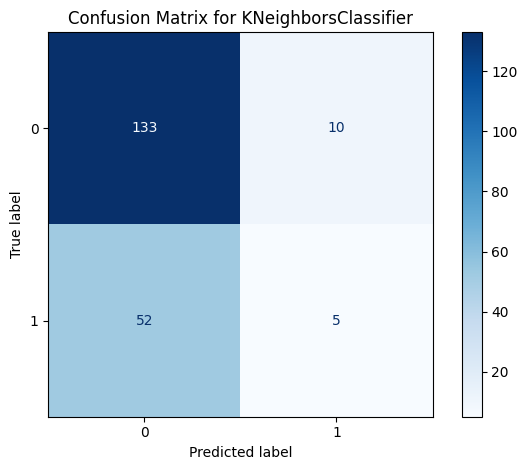

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83       143
           1       0.50      0.11      0.17        57

    accuracy                           0.71       200
   macro avg       0.61      0.53      0.50       200
weighted avg       0.66      0.71      0.64       200



KNeighborsClassifier Accuracy: 0.71
KNeighborsClassifier F1 score: 0.64


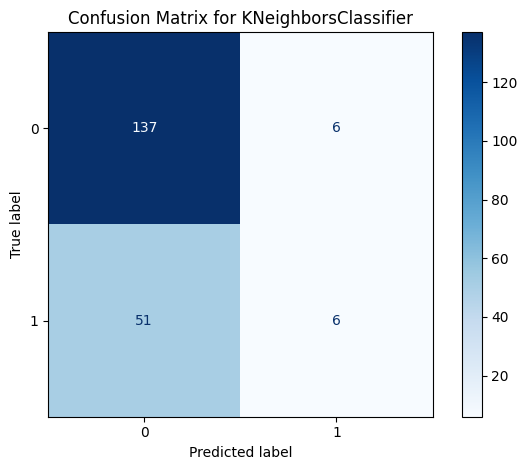

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.71      0.99      0.83       143
           1       0.00      0.00      0.00        57

    accuracy                           0.70       200
   macro avg       0.36      0.49      0.41       200
weighted avg       0.51      0.70      0.59       200



KNeighborsClassifier Accuracy: 0.70
KNeighborsClassifier F1 score: 0.59


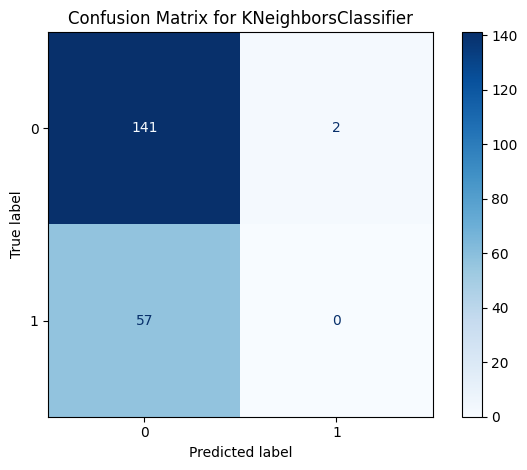

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.72      0.99      0.83       143
           1       0.50      0.04      0.07        57

    accuracy                           0.71       200
   macro avg       0.61      0.51      0.45       200
weighted avg       0.66      0.71      0.61       200



KNeighborsClassifier Accuracy: 0.71
KNeighborsClassifier F1 score: 0.61


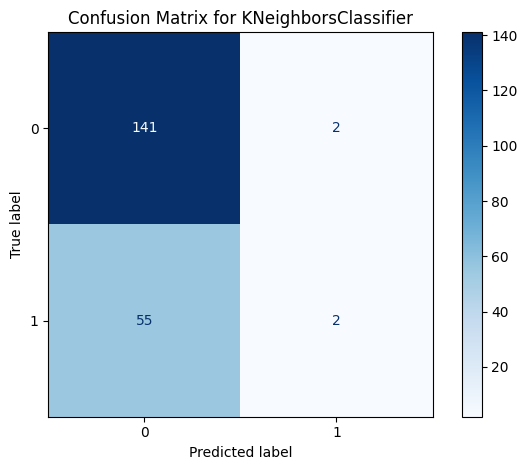

In [11]:
# Run a baseline version of KNN on the insurance claims dataset with one-hot encoding and without
base_ins_oh_model, base_ins_oh_pred, base_ins_oh_results = classifier_model(
    KNeighborsClassifier,
    X_train_ins_oh,
    y_train_ins_oh,
    X_test_ins_oh,
    y_test_ins_oh
)

base_ins_en_model, base_ins_en_pred, base_ins_en_results = classifier_model(
    KNeighborsClassifier, 
    X_train_ins_en, 
    y_train_ins_en, 
    X_test_ins_en, 
    y_test_ins_en
)

# Run the classifier model bunction with the best parameters from gridsearch
grid_ins_oh_model, grid_ins_oh_pred, grid_ins_oh_results = classifier_model(
    KNeighborsClassifier, 
    X_train_ins_oh, 
    y_train_ins_oh, 
    X_test_ins_oh, 
    y_test_ins_oh, 
    **grid_best_params_ins_oh
)

grid_ins_en_model, grid_ins_en_pred, grid_ins_en_results = classifier_model(
    KNeighborsClassifier,
    X_train_ins_en,
    y_train_ins_en,
    X_test_ins_en,
    y_test_ins_en,
    **grid_best_params_ins_en
)

In [12]:
# DataFrame of the Insurance Claims results
df_ins_results = pd.DataFrame({
    'base_oh': base_ins_oh_results,
    'base_en': base_ins_en_results,
    'grid_oh': grid_ins_oh_results,
    'grid_en': grid_ins_en_results
})

# Print the results DataFrame
print("\nInsurance Claims Results DataFrame:")
df_ins_results


Insurance Claims Results DataFrame:


,base_oh,base_en,grid_oh,grid_en
model_name,KNeighborsClassifier,KNeighborsClassifier,KNeighborsClassifier,KNeighborsClassifier
model_params,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...","{'algorithm': 'auto', 'leaf_size': 30, 'metric...","{'algorithm': 'auto', 'leaf_size': 30, 'metric...","{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
accuracy,0.69,0.715,0.705,0.715
f1_score,0.619431,0.641438,0.59129,0.613467


## Car Claims Dataset

In [13]:
# Run Gridsearch on the insurance claims dataset with one-hot encoding
car_oh_param_grid = {
    'n_neighbors': range(1,10),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_best_params_car_oh, grid_cv_score_car_oh = gridsearchcv(
    KNeighborsClassifier, X_train_car_oh, y_train_car_oh, param_dict=car_oh_param_grid, random_state=random_state, scoring='accuracy', cv=5)


Search Results (Top 5):

algorithm  n_neighbors  p  weights  mean_cv_score  std_cv_score  mean_train_score  std_train_score
     auto            8  2  uniform       0.939932      0.000165          0.940216         0.000171
     auto            8  1  uniform       0.939932      0.000165          0.940337         0.000134
     auto            9  2 distance       0.939932      0.000398          1.000000         0.000000
  kd_tree            8  1  uniform       0.939932      0.000165          0.940337         0.000134
  kd_tree            8  2  uniform       0.939932      0.000165          0.940216         0.000171

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}
Best CV Score: 0.9399


In [14]:
# Run Gridsearch on the insurance claims dataset with one-hot encoding
car_en_param_grid = {
    'n_neighbors': range(1,10),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_best_params_car_en, grid_cv_score_car_en = gridsearchcv(
    KNeighborsClassifier, X_train_car_en, y_train_car_en, param_dict=car_en_param_grid, random_state=random_state, scoring='accuracy', cv=5)


Search Results (Top 5):

algorithm  n_neighbors  p  weights  mean_cv_score  std_cv_score  mean_train_score  std_train_score
     auto            9  1 distance       0.940742      0.001194          1.000000         0.000000
ball_tree            9  1 distance       0.940742      0.001194          1.000000         0.000000
  kd_tree            9  1 distance       0.940742      0.001194          1.000000         0.000000
    brute            9  1 distance       0.940742      0.001194          1.000000         0.000000
ball_tree            6  1  uniform       0.940580      0.000657          0.942648         0.000281

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Best CV Score: 0.9407


Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2902
           1       0.50      0.03      0.05       182

    accuracy                           0.94      3084
   macro avg       0.72      0.51      0.51      3084
weighted avg       0.92      0.94      0.92      3084



KNeighborsClassifier Accuracy: 0.94
KNeighborsClassifier F1 score: 0.92


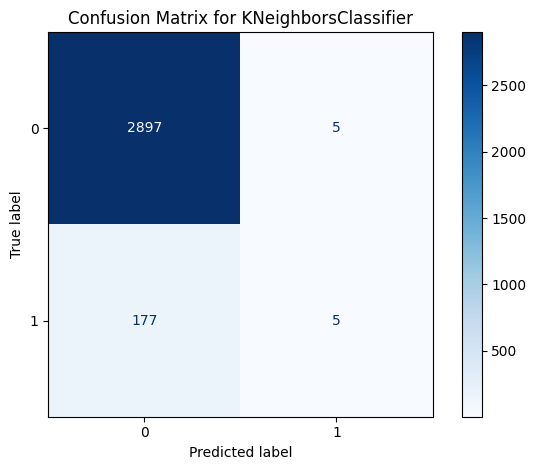

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2902
           1       0.29      0.04      0.07       182

    accuracy                           0.94      3084
   macro avg       0.62      0.52      0.52      3084
weighted avg       0.90      0.94      0.91      3084



KNeighborsClassifier Accuracy: 0.94
KNeighborsClassifier F1 score: 0.91


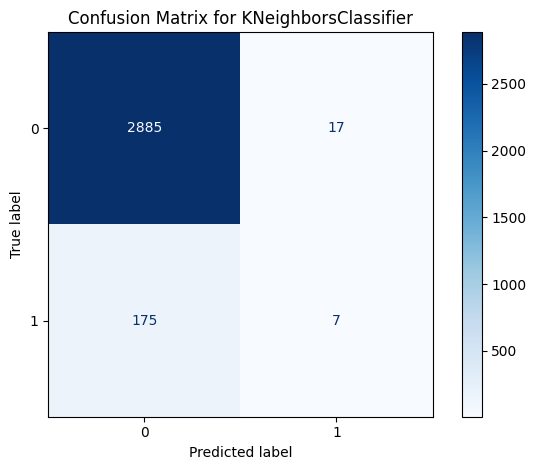

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2902
           1       0.00      0.00      0.00       182

    accuracy                           0.94      3084
   macro avg       0.47      0.50      0.48      3084
weighted avg       0.89      0.94      0.91      3084



KNeighborsClassifier Accuracy: 0.94
KNeighborsClassifier F1 score: 0.91


c:\Users\JT von Seggern\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\JT von Seggern\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\JT von Seggern\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

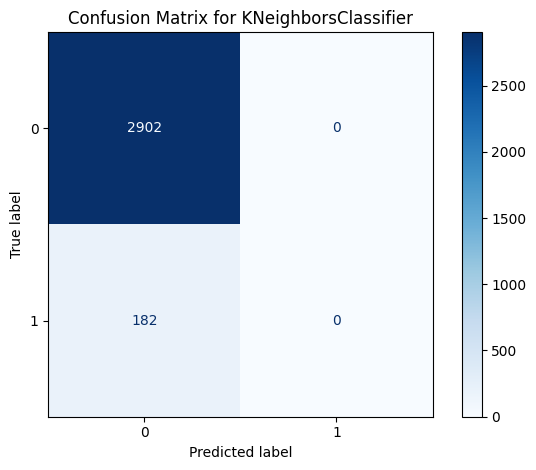

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2902
           1       0.60      0.02      0.03       182

    accuracy                           0.94      3084
   macro avg       0.77      0.51      0.50      3084
weighted avg       0.92      0.94      0.91      3084



KNeighborsClassifier Accuracy: 0.94
KNeighborsClassifier F1 score: 0.91


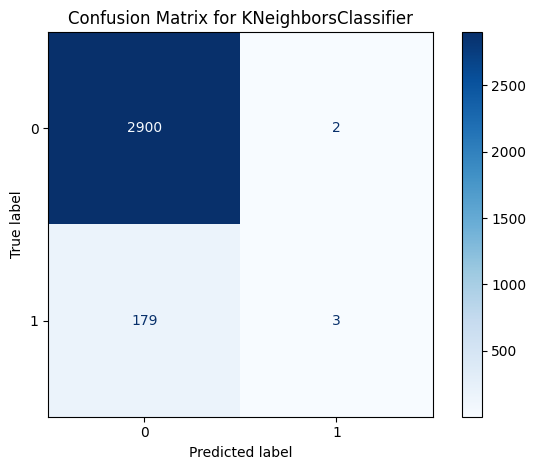

In [15]:
# Run a baseline version of KNN on the insurance claims dataset with one-hot encoding and without
base_car_oh_model, base_car_oh_pred, base_car_oh_results = classifier_model(
    KNeighborsClassifier,
    X_train_car_oh,
    y_train_car_oh,
    X_test_car_oh,
    y_test_car_oh
)

base_car_en_model, base_car_en_pred, base_car_en_results = classifier_model(
    KNeighborsClassifier, 
    X_train_car_en, 
    y_train_car_en, 
    X_test_car_en, 
    y_test_car_en
)

# Run the classifier model bunction with the best parameters from gridsearch
grid_car_oh_model, grid_car_oh_pred, grid_car_oh_results = classifier_model(
    KNeighborsClassifier, 
    X_train_car_oh, 
    y_train_car_oh, 
    X_test_car_oh, 
    y_test_car_oh, 
    **grid_best_params_car_oh
)

grid_car_en_model, grid_car_en_pred, grid_car_en_results = classifier_model(
    KNeighborsClassifier,
    X_train_car_en,
    y_train_car_en,
    X_test_car_en,
    y_test_car_en,
    **grid_best_params_car_en
)

In [16]:
# DataFrame of the Insurance Claims results
df_car_results = pd.DataFrame({
    'base_oh': base_car_oh_results,
    'base_en': base_car_en_results,
    'grid_oh': grid_car_oh_results,
    'grid_en': grid_car_en_results
})

# Print the results DataFrame
print("\nCar Claims Results DataFrame:")
df_car_results


Car Claims Results DataFrame:


,base_oh,base_en,grid_oh,grid_en
model_name,KNeighborsClassifier,KNeighborsClassifier,KNeighborsClassifier,KNeighborsClassifier
model_params,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...","{'algorithm': 'auto', 'leaf_size': 30, 'metric...","{'algorithm': 'auto', 'leaf_size': 30, 'metric...","{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
accuracy,0.940986,0.937743,0.940986,0.94131
f1_score,0.915402,0.914693,0.912376,0.914403


The results of the Car Claims dataset was similar to eariler iterations of classification methods, the class imbalance of the target variable leads the model to predict majority True Negative, aka No Fraud Found. Will continue to experiment with weight balancing parameters for the class imbalance however, it seems to be a major factor in the models being able to predict correctly.